In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_parquet("data/processed_data.parquet")   

In [3]:
dt_columns = df.columns[df.columns.str.startswith("DT_")].to_list()

In [4]:
cd_columns = df.columns[df.columns.str.startswith("CD_")].to_list()

In [5]:
gn_columns = df.columns[df.columns.str.startswith("GN_")].to_list()

In [6]:
fl_columns = df.columns[df.columns.str.startswith("FL_")].to_list()

In [7]:
excluded_columns = set(dt_columns) | set(cd_columns) | set(gn_columns) | set(fl_columns) 
other_columns = [col for col in df.columns if col not in excluded_columns]

In [8]:
columns_keep = [
 "DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE",
 "DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE",
 'CD_DATA_OWNER_LOGICAL_REGION_CODE',
 'CD_COMMERCIAL_ORDER_CODE',
 'CD_BRAND_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_ORIGINAL_CODE',
 'CD_VEHICLE_CAR_LINE_CODE',
 'CD_MODEL_CODE',
 'CD_VEHICLE_PRODUCT_LINE_CODE',
 'CD_VEHICLE_COMMERCIAL_FAMILY_ORIGIN_CODE',
 'CD_VEHICLE_VERSION_CODE',
 'CD_REGION_CODE',
 'CD_SALES_REGION_CODE',
 'CD_MARKET_CODE',
 'CD_PROGRAMMING_MARKET_CODE',
 'CD_PLANT_LOGISTIC_CODE',
 'CD_FINAL_CUSTOMER_ORDER_CODE',
 'CD_VEHICLE_ORDER_ORIGIN_CODE',
 'CD_COMMERCIAL_ORDER_STATUS_CODE',
 'GN_BRAND_ORIGINAL_NAME',
 'GN_VEHICLE_COMPLETE_DESCRIPTION_NAME',
 'GN_VEHICLE_CAR_LINE_NAME',
 'GN_CUSTOMER_SALES_CHANNEL_NAME',
 "FL_IS_ORDER_ACTIVE_FLAG",
 "FL_IS_VEHICLE_FOR_SHOWROOM_FLAG",
 "FL_IS_VEHICLE_FOR_DEMOSTRATION_FLAG",
 "FL_IS_FINAL_CUSTOMER_ORDER_ISSUED_FLAG",
 "FL_IS_ONLINE_SALES_FLAG",
 "FL_IS_DIRECT_SALES_FLAG",
 "CD_SHIPPING_ZONE_CODE",
 'IS_INTERNATIONAL', 
 'is_missing_CD_FINAL_CUSTOMER_ORDER_CODE',
 'is_missing_CD_VEHICLE_ORDER_ORIGIN_CODE',
 'Is_Delayed',
 'REG_Delay_Days',
 'Destination_Type'
    ]

In [9]:
# Selected features
df_filtred = df[columns_keep].copy()

In [10]:
df_filtred["GN_CUSTOMER_SALES_CHANNEL_NAME"].fillna(df_filtred["GN_CUSTOMER_SALES_CHANNEL_NAME"].mode()[0],
                                                    inplace=True)

In [11]:
cat_cols = ['CD_DATA_OWNER_LOGICAL_REGION_CODE',
 'CD_COMMERCIAL_ORDER_CODE',
 'CD_BRAND_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_ORIGINAL_CODE',
 'CD_VEHICLE_CAR_LINE_CODE',
 'CD_MODEL_CODE',
 'CD_VEHICLE_PRODUCT_LINE_CODE',
 'CD_VEHICLE_COMMERCIAL_FAMILY_ORIGIN_CODE',
 'CD_VEHICLE_VERSION_CODE',
 'CD_REGION_CODE',
 'CD_SALES_REGION_CODE',
 'CD_MARKET_CODE',
 'CD_PROGRAMMING_MARKET_CODE',
 'CD_PLANT_LOGISTIC_CODE',
 'CD_FINAL_CUSTOMER_ORDER_CODE',
 'CD_VEHICLE_ORDER_ORIGIN_CODE',
 'CD_COMMERCIAL_ORDER_STATUS_CODE',
 'GN_BRAND_ORIGINAL_NAME',
 'GN_VEHICLE_COMPLETE_DESCRIPTION_NAME',
 'GN_VEHICLE_CAR_LINE_NAME',
 'GN_CUSTOMER_SALES_CHANNEL_NAME',
 "CD_SHIPPING_ZONE_CODE",
 "Destination_Type"]

In [12]:
for col in cat_cols:
    le = LabelEncoder()
    df_filtred[col] = le.fit_transform(df_filtred[col].astype(str))

In [13]:
df_filtred['ORDER_CREATION_MONTH'] = pd.to_datetime(df_filtred['DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE']).dt.month
df_filtred['ORDER_CREATION_WEEKDAY'] = pd.to_datetime(df_filtred['DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE']).dt.weekday
df_filtred['ORDER_CREATION_YEAR'] = pd.to_datetime(df_filtred['DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE']).dt.year

In [14]:
df_filtred['ORDER_EXPECTED_MONTH'] = pd.to_datetime(df_filtred['DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE']).dt.month
df_filtred['ORDER_EXPECTED_WEEKDAY'] = pd.to_datetime(df_filtred['DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE']).dt.weekday
df_filtred['ORDER_EXPECTED_YEAR'] = pd.to_datetime(df_filtred['DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE']).dt.year

In [15]:
df_filtred.drop(columns=["DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE",
                         "DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE"],inplace=True)

In [16]:
exclude = ['REG_Delay_Days', 'Is_Delayed']
X = df_filtred[[col for col in df_filtred.columns if col not in exclude]]
y_class = df_filtred['Is_Delayed']
y_reg = df_filtred['REG_Delay_Days']

In [17]:
# CatBoost accepts string or pandas 'category' dtype as categorical:
cat_cols = [c for c in X.columns if str(X[c].dtype)=='category' or X[c].dtype=='object']

# Train/valid split  (same indices for both tasks)
X_train, X_valid, y_reg_train, y_reg_valid = train_test_split(
        X, y_reg, test_size=0.2, random_state=42, stratify=y_class)

y_clf_train = y_class.loc[X_train.index]
y_clf_valid = y_class.loc[X_valid.index]

# Give CatBoost the list **of column indices** (fastest) or names.
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

In [18]:
train_pool_reg = Pool(X_train, y_reg_train, cat_features=cat_idx)
valid_pool_reg = Pool(X_valid, y_reg_valid, cat_features=cat_idx)

train_pool_clf = Pool(X_train, y_clf_train, cat_features=cat_idx)
valid_pool_clf = Pool(X_valid, y_clf_valid, cat_features=cat_idx)

In [19]:
reg_params = dict(
    iterations=2000,                # big number + early stopping
    learning_rate=0.05,
    depth=8,
    loss_function='MAE',            # or 'RMSE'
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=200
)

In [20]:
regressor = CatBoostRegressor(**reg_params)
regressor.fit(train_pool_reg, eval_set=valid_pool_reg)

# ----  Evaluation ----
pred_reg = regressor.predict(X_valid)

0:	learn: 67.6684277	test: 61.9411722	best: 61.9411722 (0)	total: 59.5ms	remaining: 1m 58s
200:	learn: 51.7038408	test: 47.7195552	best: 47.7195552 (200)	total: 2.27s	remaining: 20.3s
400:	learn: 46.7199523	test: 46.1533602	best: 46.1533602 (400)	total: 4.26s	remaining: 17s
600:	learn: 43.5847155	test: 44.8126298	best: 44.8031522 (590)	total: 6.5s	remaining: 15.1s
800:	learn: 41.8991325	test: 44.0337237	best: 44.0261771 (797)	total: 9.02s	remaining: 13.5s
1000:	learn: 40.1760053	test: 43.5599061	best: 43.5588570 (980)	total: 11.6s	remaining: 11.6s
1200:	learn: 38.6052289	test: 43.4072814	best: 43.4072814 (1200)	total: 13.5s	remaining: 9s
1400:	learn: 37.5790913	test: 43.3321655	best: 43.3231017 (1376)	total: 15.5s	remaining: 6.65s
1600:	learn: 36.5817136	test: 43.1749093	best: 43.1740661 (1597)	total: 17.5s	remaining: 4.36s
1800:	learn: 35.7971493	test: 43.0271481	best: 43.0248941 (1778)	total: 19.3s	remaining: 2.13s
1999:	learn: 35.1148423	test: 42.9503233	best: 42.9397540 (1974)	tota

In [21]:
mae  = mean_absolute_error(y_reg_valid, pred_reg)
rmse = mean_squared_error(y_reg_valid, pred_reg, squared=False)

print(f"MAE  : {mae:0.2f}")
print(f"RMSE : {rmse:0.2f}")

MAE  : 19.58
RMSE : 42.94


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
clf_params = dict(
    iterations=3000,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=150,
    class_weights=[1, 3],   # optional: handle imbalance
    verbose=200
)

In [23]:
classifier = CatBoostClassifier(**clf_params)
classifier.fit(train_pool_clf, eval_set=valid_pool_clf)

0:	test: 0.7098120	best: 0.7098120 (0)	total: 31.6ms	remaining: 1m 34s
200:	test: 0.8154526	best: 0.8154615 (197)	total: 3.07s	remaining: 42.8s
400:	test: 0.8220030	best: 0.8233822 (348)	total: 5.22s	remaining: 33.9s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8233822435
bestIteration = 348

Shrink model to first 349 iterations.


In [24]:
# ----  Evaluation ----
pred_proba = classifier.predict_proba(X_valid)[:,1]
pred_class = (pred_proba >= 0.5).astype(int)

acc  = accuracy_score(y_clf_valid, pred_class)
auc  = roc_auc_score(y_clf_valid, pred_proba)

print(f"Accuracy : {acc:0.3f}")
print(f"AUC      : {auc:0.3f}")

Accuracy : 0.703
AUC      : 0.823


In [25]:
%%capture
!pip install shap

In [26]:
import shap

shap.initjs()

In [27]:
import shap
shap_vals = classifier.get_feature_importance(valid_pool_clf,
                                         type='ShapValues')          # (rows, features+1)
# Last column is expected value → drop it
shap_imp  = abs(shap_vals[:,:-1]).mean(axis=0)

shap_df   = pd.DataFrame({'feature': X.columns,
                          'mean_abs_SHAP': shap_imp}) \
              .sort_values('mean_abs_SHAP', ascending=False)

In [28]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X)

In [29]:
shap.plots.force(shap_values[0, ...])

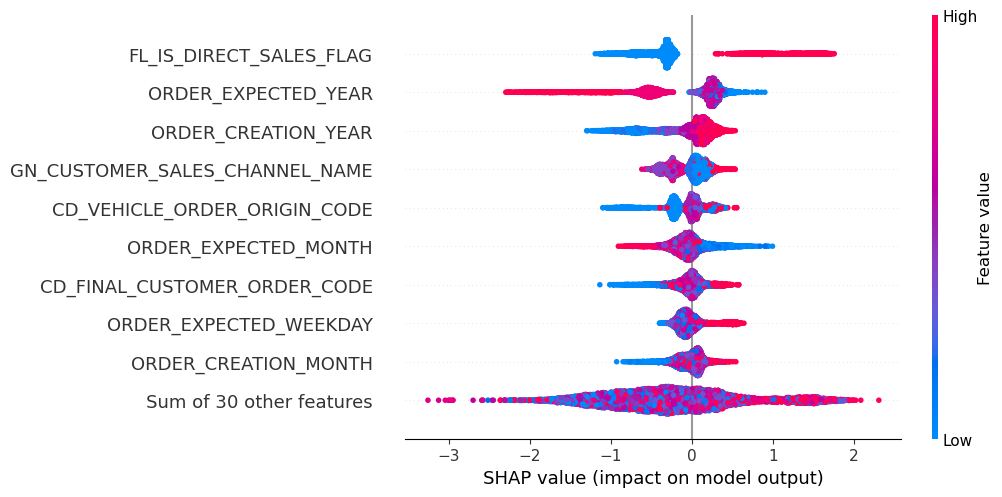

In [30]:
shap.plots.beeswarm(shap_values)

In [ ]:
# visualize the training set predictions
shap.plots.force(shap_values)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/shap/plots/_force.py:211: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")
